## **CV|MDSE@FEUP**
### **Group:**
* Fábio Silva (202003096)
* Joana Leite (202003076)

<br>

# Assignment 1
5-19/nov/2021

## **a)** Calibration of the intrinsic parameters and lens distortion of the camera.

Code adapted from the [OpenCV Camera Calibration tutorial](https://docs.opencv.org/4.5.3/dc/dbb/tutorial_py_calibration.html).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import cv2 as cv
import glob
from google.colab.patches import cv2_imshow 

# cv2.imshow() is disabled in Colab, because it causes Jupyter sessions
# to crash; see https://github.com/jupyter/notebook/issues/3935. As a substitution, consider using
# from google.colab.patches import cv2_imshow

# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((4*7,3), np.float32)   # Changed the number of corners
objp[:,:2] = np.mgrid[0:7,0:4].T.reshape(-1,2)   # Changed the number of corners

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

# images = glob.glob('IntrinsicCalibration/*.png')  # Changed folder
images = glob.glob('/content/drive/MyDrive/CV/CV_Assig_1/IntrinsicCalibration/*.png')  # Changed folder

In [3]:
for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (7,4), None)   # Changed the number of corners
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners)
        # Draw and display the corners
        cv.drawChessboardCorners(img, (7,4), corners2, ret)   # Changed the number of corners
        #cv2_imshow(img)   # Changed from 'img' to fname so that all windows are kept open
        #print("\n")
        #cv.waitKey(500)

In [4]:
#Calibration
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [5]:
# ret is the overall RMS re-projection error. The reprojection error is a geometric error corresponding
# to the image distance between a projected point and a measured one.
print('RMS re-projection error \n', ret) 
print('\n camera matrix \n', mtx)
print('\n distortion coefficients \n', dist)
#print('rotation vectors \n', rvecs)
#print('translation vectors \n', tvecs)

RMS re-projection error 
 0.4916771746952465

 camera matrix 
 [[1.32164964e+03 0.00000000e+00 9.88299720e+02]
 [0.00000000e+00 1.32444624e+03 6.42259045e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

 distortion coefficients 
 [[-3.44269868e-01  9.00566926e-02  9.45446308e-05 -3.97945887e-04
  -3.15663100e-03]]


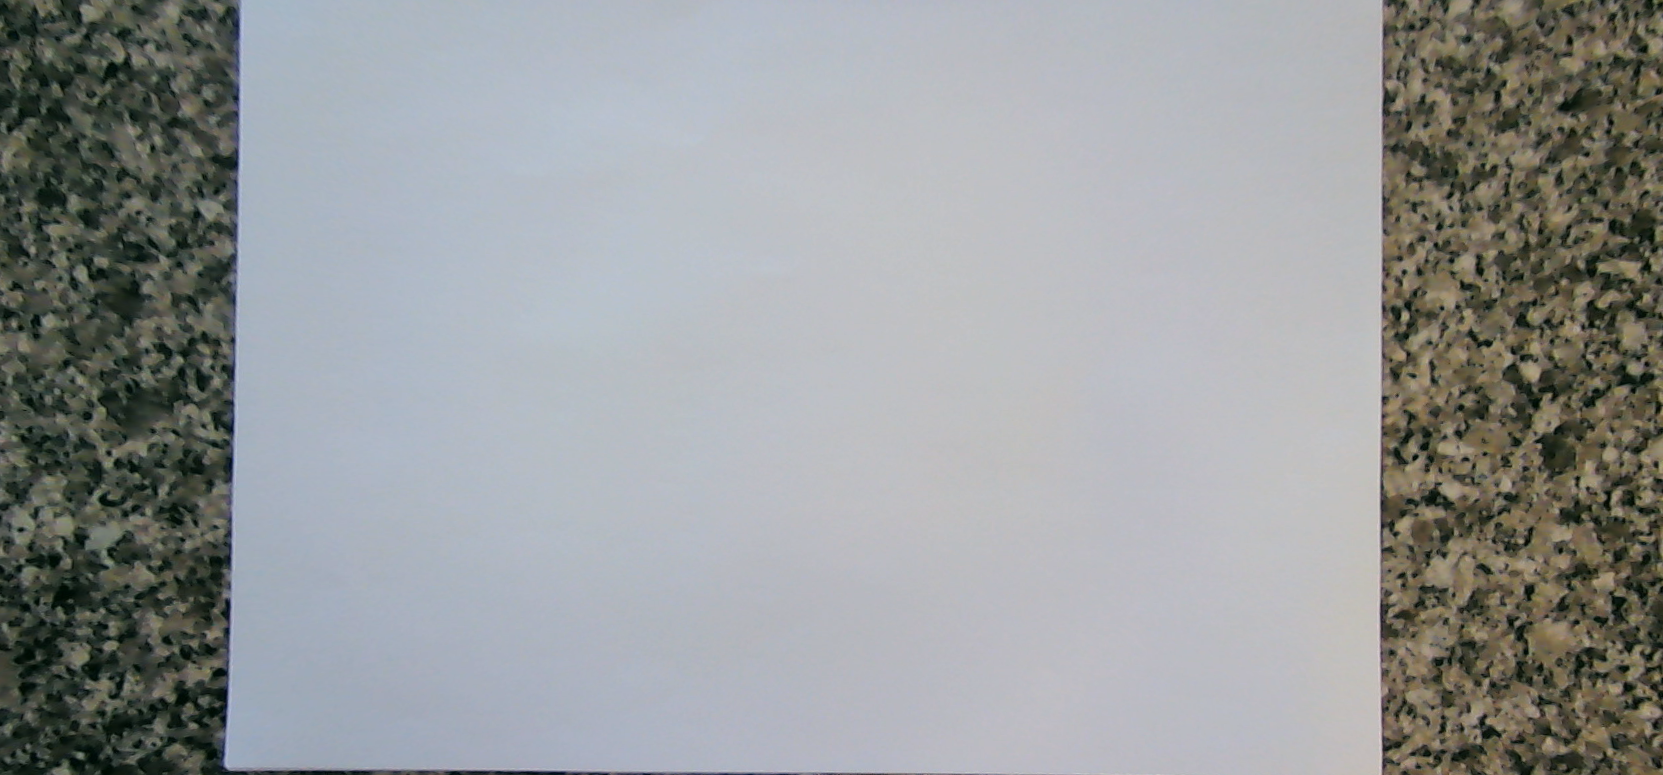

In [6]:
# Experiment: undistorting an image

img = cv.imread('/content/drive/MyDrive/CV/CV_Assig_1/WhiteBackground/calib_img 0.png')
h, w = img.shape[:2]
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

# undistort
dst = cv.undistort(img, mtx, dist, None, newcameramtx)
# crop the image
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
cv2_imshow(dst)

In [7]:
#Re-projection Error
mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv.norm(imgpoints[i], imgpoints2, cv.NORM_L2)/len(imgpoints2)
    mean_error += error
print( "total error: {}".format(mean_error/len(objpoints)) )

total error: 0.08655261491935715


## **b)** Calibration of the extrinsic parameters of the camera setup.

Extrinsic parameters corresponds to rotation and translation vectors which translates a coordinates of a 3D point to a coordinate system. <br>
from: https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html

Information about the chessboard: 5x8 squares and size of a square = 21mm

In [8]:
# from: https://medium.com/vacatronics/3-ways-to-calibrate-your-camera-using-opencv-and-python-395528a51615

image = ('/content/drive/MyDrive/CV/CV_Assig_1/GreyBackground/extrinsic.png')  # Changed folder

SQUARE_SIZE = 2.1

# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((4*7,3), np.float32)   # Changed the number of corners
objp[:,:2] = (SQUARE_SIZE*np.mgrid[0:7,0:4]).T.reshape(-1,2)   # Changed the number of corners

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

img = cv.imread(image)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
# Find the chess board corners
ret, corners = cv.findChessboardCorners(gray, (7,4), None)   # Changed the number of corners
# If found, add object points, image points (after refining them)
if ret == True:
    objpoints.append(objp)
    corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
    imgpoints.append(corners)

ret_b, mtx_b, dist_b, rvecs_b, tvecs_b = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, dist)

In [9]:
for i in range(len(rvecs_b)):
  print("rvec img {}\n".format(i), rvecs_b[i], "\n", "tvecs img {}\n".format(i), tvecs_b[i], "\n")

rvec img 0
 [[-0.00797855]
 [ 0.00843659]
 [ 3.13804928]] 
 tvecs img 0
 [[7.29348855]
 [1.63258281]
 [9.75515935]] 



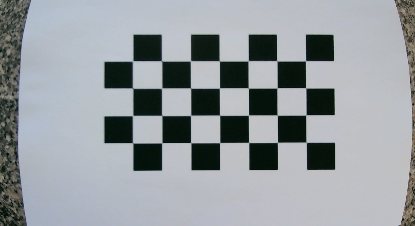

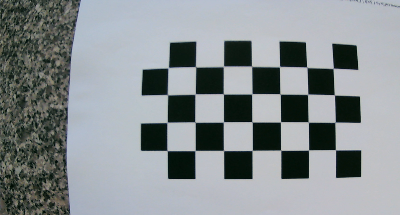

In [10]:
image = ('/content/drive/MyDrive/CV/CV_Assig_1/GreyBackground/extrinsic.png')
img = cv.imread(image)
h, w = img.shape[:2]
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx_b, dist_b, (w,h), 1, (w,h))
# undistort
dst = cv.undistort(img, mtx_b, dist_b, None, newcameramtx)
# crop the image
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
small = cv.resize(dst, (0,0), fx=0.25, fy=0.25) ## resize by 25%
cv2_imshow(small)
print("\n")

newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
# undistort
dst = cv.undistort(img, mtx, dist, None, newcameramtx)
# crop the image
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
small = cv.resize(dst, (0,0), fx=0.25, fy=0.25) ## resize by 25%
cv2_imshow(small)

Resultado da foto 1 mostra que calibrou na zona do xadrez. isto feito com a nova calibração que tem em conta o size do quadrado <br><
Na foto 2 era a mesma imagem "undistort" com base na calibração 1 que nem foi feita com esta imagem (calibração 1 feita com imagens da pasta (InstrinsicCalibration). Foi um teste um bocado tira teimas e para comparar as calibrações

## **c)** Considering only the images retrieved from a **White Background**:

In [11]:
def own_undistort(img, mtx, dist):
  h, w = img.shape[:2]
  newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
  # undistort
  dst = cv.undistort(img, mtx, dist, None, newcameramtx)
  # crop the image
  x, y, w, h = roi
  dst = dst[y:y+h, x:x+w]
  #small = cv.resize(dst, (0,0), fx=0.25, fy=0.25) ## resize by 25%
  #cv2_imshow(small)
  #cv2_imshow(dst)
  return dst

In [12]:
images = glob.glob('/content/drive/MyDrive/CV/CV_Assig_1/WhiteBackground/calib_img*.png')  # Changed folder

### **I.** Define a ROI (region of interest);

In [13]:
images_corrected = []               # undistort 
for fname in images:
    img = cv.imread(fname)
    img = cv.medianBlur(img,9)
    img = cv.resize(img, (0,0), fx=0.2, fy=0.2) ## resize by n% to be faster pffffff ;)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img = own_undistort(img, mtx, dist)
    #cv2_imshow(img)   # Changed from 'img' to fname so that all windows are kept open
    #print("\n")
    images_corrected.append(img)

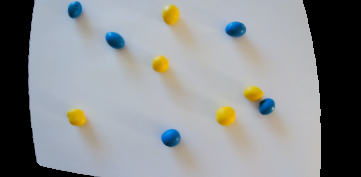

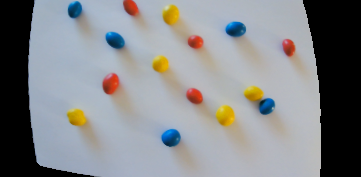

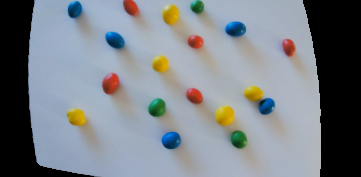

In [14]:
# vou a 1ª imagem e retiro a mascara do que é branco. A câmara esta sempre naquela posição portanto nas outras imagens, os m&m vão estar sempre
# naquela zona branca
for img in images_corrected:
  img = cv.medianBlur(img,9)
  img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
  #cv2_imshow(img)
  #print("\n")

  # white
  sensitivity = 100
  lower_white = (0,0,255-sensitivity)
  upper_white = (255,sensitivity,255)
  mask_white = cv.inRange(img_hsv, lower_white, upper_white)
  mask_image = cv.bitwise_and(img_hsv, img_hsv, mask=mask_white)
  img_white = cv.cvtColor(mask_image, cv.COLOR_HSV2BGR)
  #cv2_imshow(img_white)
  #print("\n")
  break

# aplico a mascara da 1ª imagem nas outras e removo o granito das imagens 
images_roi_defined = []    
images_corrected.pop(0)  # remove a 1ª imagem que só tem a folha de papel          
for img in images_corrected:
  img = cv.cvtColor(img, cv.COLOR_BGR2HSV)
  img = cv.bitwise_and(img,img,mask = mask_white)   
  img = cv.cvtColor(img, cv.COLOR_HSV2BGR)
  images_roi_defined.append(img)
  cv2_imshow(img)
  print("\n")

### **II.** Calculate the color distribution (up to 4);

## Notes: 
###Histogram Equalization <br>
#### * It is a graphical representation of the intensity distribution of an image. <br>
#### * It quantifies the number of pixels for each intensity value considered


In [15]:
from matplotlib.pyplot import figure
from matplotlib import pyplot as plt
import operator

figure(figsize=(300, 300), dpi=80)

<Figure size 24000x24000 with 0 Axes>

<Figure size 24000x24000 with 0 Axes>

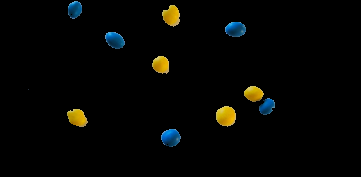

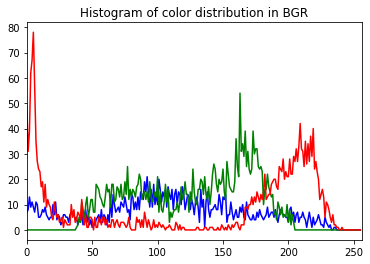

Red: [34.24]%; Green: [38.55]%; Blue: [27.21]%
___________________________________________



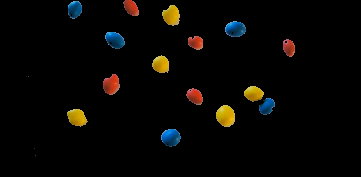

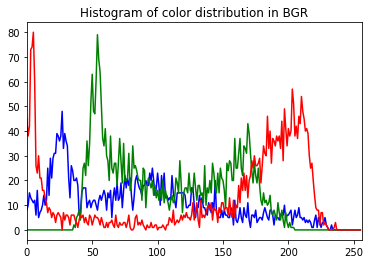

Red: [33.94]%; Green: [36.84]%; Blue: [29.21]%
___________________________________________



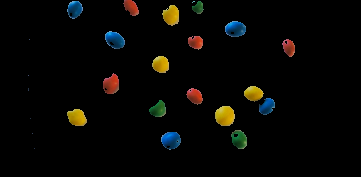

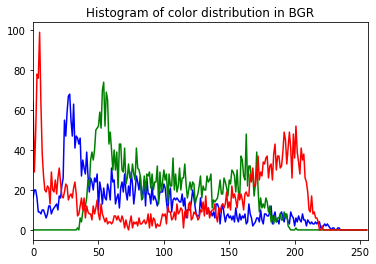

Red: [33.77]%; Green: [36.13]%; Blue: [30.09]%
___________________________________________



In [16]:
images_only_with_MandM = []

for img in images_roi_defined:
  img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
  #cv2_imshow(img)
  #print("\n")

  # red low
  lower_red = (0, 100, 100)
  upper_red = (15, 255, 255)
  mask_red_low = cv.inRange(img_hsv, lower_red, upper_red)
  # red high
  lower_red = (150, 100, 100)
  upper_red = (180, 255, 255)
  mask_red_high = cv.inRange(img_hsv, lower_red, upper_red)
  # combine masks
  mask_red = cv.bitwise_or(mask_red_low, mask_red_high) 
  img_red = cv.bitwise_or(img_hsv, img_hsv, mask=mask_red)
  #cv2_imshow(img_red)

  # blue
  lower_blue = (90,100,60)
  upper_blue = (120,255,255)
  mask_blue = cv.inRange(img_hsv, lower_blue, upper_blue)
  img_blue = cv.bitwise_and(img_hsv, img_hsv, mask=mask_blue)
  #cv2_imshow(img_blue)

  # yellow
  lower_yellow = (20,100,100)
  upper_yellow = (35,255,255)
  mask_yellow = cv.inRange(img_hsv, lower_yellow, upper_yellow)
  img_yellow = cv.bitwise_and(img_hsv, img_hsv, mask=mask_yellow)
  #cv2_imshow(img_yellow)

  # green
  lower_green = (35,50,0)
  upper_green = (75,255,255)
  mask_green = cv.inRange(img_hsv, lower_green, upper_green)
  img_green = cv.bitwise_and(img_hsv, img_hsv, mask=mask_green)
  #cv2_imshow(img_green)

  combined_masks = cv.bitwise_or(mask_blue, mask_red)
  combined_masks = cv.bitwise_or(combined_masks, mask_yellow) 
  combined_masks = cv.bitwise_or(combined_masks, mask_green)
  img_roi = cv.bitwise_and(img_hsv, img_hsv, mask=combined_masks)
  img_roi_bgr = cv.cvtColor(img_roi, cv.COLOR_HSV2BGR)
  cv2_imshow(img_roi_bgr)
  print("\n")

  images_only_with_MandM.append(img_roi_bgr) 

  # adapted from https://stackoverflow.com/questions/43167867/color-percentage-in-image-python-opencv-using-histogram
  color = ('b','g','r')
  qtdBlue = 0
  qtdGreen = 0
  qtdRed = 0
  totalPixels = 0

  for channel,col in enumerate(color):
    histr = cv.calcHist([img_roi_bgr],[channel],None,[256],[1,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])

    totalPixels+=sum(histr)
    if channel==0:
      qtdBlue = sum(histr)
    elif channel==1:
      qtdGreen = sum(histr)
    elif channel==2:
      qtdRed = sum(histr)
  
  qtdBlue = (qtdBlue/totalPixels)*100
  qtdGreen = (qtdGreen/totalPixels)*100
  qtdRed = (qtdRed/totalPixels)*100

  plt.title('Histogram of color distribution in BGR')
  plt.show()

  print("Red: "+str(np.round(qtdRed,2))+"%; Green: "+str(np.round(qtdGreen,2))+"%; Blue: "+str(np.round(qtdBlue,2))+"%")
  print("___________________________________________\n")


### **III**. Determine the shape area for the chocolate peanuts in pixels;

### **IV**. Determine the shape area for chocolate peanuts in millimeters and group by color;

### **V**. Show a histogram of the shape areas of the chocolate peanuts for the entire sample;

### **VI**. Provide some recommendations that the M&M factory should take into consideration to improve the performance of the quality assurance process based on image processing (e.g., imaging setup, calibration process and photometric effects).